In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding:utf-8 -*-
from pylab import *
from numpy import *
import pandas as pd
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import random
import copy
import time
from sklearn.decomposition import PCA

In [ ]:
# 初始化模糊矩阵（隶属度矩阵 U）
# 用值在0，1间的随机数初始化隶属矩阵，得到c列的U，使其满足隶属度之和为1
def initialize():
    # 返回一个模糊矩阵的列表
    U = list()
    # 标准化
    for i in range(n):
        # 初始化，给与随机的隶属度
        random_list = [random.random() for i in range(Clusters_number)]
        # print(random_list)
        # 标准化：值/每列的和
        summation = sum(random_list)
        # print(summation)
        temp_list = [x / summation for x in random_list]
        # print(temp_list)
        U.append(temp_list)
    return U

In [ ]:
# 计算中心矩阵 V
def calculateCenter(U):
    # zip函数实现矩阵的转置 https://blog.csdn.net/qinze5857/article/details/80447835
    U_zhuanzhi = list(zip(*U))
    # 中心矩阵，列表
    V = list()
    for j in range(Clusters_number):
        # 取出转置矩阵每列的150个元素
        x = U_zhuanzhi[j]
        # uij的m次方，m为模糊参数
        xraised = [e ** m for e in x]
        # 分母
        denominator = sum(xraised)
        temp_num = list()
        for i in range(n):
            # 得到分子中的 xj
            data_point = list(data.iloc[i])
            # uij的m次方 乘以 xj
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        # 分子：上面的结果求和
        numerator = map(sum, zip(*temp_num))
        # 求聚类中心
        center = [z / denominator for z in numerator]
        # print(center)
        V.append(center)
    return V

In [ ]:
# 更新隶属度矩阵 U
def U_update(U, V):
    # 2/(m-1)
    p = float(2 / (m - 1))
    for i in range(n):
        # 取出文件中的每一行数据
        x = list(data.iloc[i])

        # 求dij
        distances = [np.linalg.norm(list(map(operator.sub, x, V[j]))) for j in range(Clusters_number)]
        for j in range(Clusters_number):
            # 分母
            den = sum([math.pow(float(distances[j] / distances[c]), p) for c in range(Clusters_number)])
            U[i][j] = float(1 / den)
    return U

In [ ]:
# 迭代，最多迭代MAX_ITER次
# 计算中心矩阵V——》更新隶属度矩阵U——》计算更新后的中心矩阵V_update，V_update和V的距离若小于阈值则停止
def iteration(U):
    # 最大迭代次数：MAX_ITER=100
    iter = 0
    while iter <= MAX_ITER:
        iter += 1
        # 计算聚类中心矩阵 V
        V = calculateCenter(U)
        # 更新模糊矩阵 U
        U = U_update(U, V)
        # 得到更新后的中心矩阵
        V_update = calculateCenter(U)
        # 如果V_update和V的距离小于阈值，迭代停止
        juli = 0
        for i in range(Clusters_number):
            for j in range(len(columns) - 1):
                juli = (V_update[i][j] - V[i][j]) ** 2 + juli
        if sqrt(juli) < Epsilon:
            break
    return V, U

In [ ]:
# 获得聚类结果（判断样本属于哪个类）
def getResult(U):
    results = list()
    # for循环取出U矩阵的150行数据
    for i in range(n):
        # 此时每条数据有3个隶属度，取最大的那个，并返回index值即0或1或2
        max_value, index = max((value, index) for (index, value) in enumerate(U[i]))
        # 以此值（0、1、2）作为结果
        results.append(index)
    return results

In [ ]:
# 主函数
def FCM():
    start = time.time()
    # 初始化模糊矩阵 U
    U = initialize()
    # 迭代，最大迭代次数：100
    V, U = iteration(U)
    # 获得聚类结果
    results = getResult(U)
    # 打印聚类所用时长
    print("用时：{0} s".format(time.time() - start))
    return results, V, U

In [ ]:
# Xie-Beni聚类有效性
def xie_beni(membership_mat, center, data):
    sum_cluster_distance = 0
    min_cluster_center_distance = inf
    for i in range(Clusters_number):
        for j in range(n):
            sum_cluster_distance = sum_cluster_distance + membership_mat[j][i] ** 2 * sum(
                power(data[j, :] - center[i, :], 2))  # 计算类一致性
    for i in range(Clusters_number - 1):
        for j in range(i + 1, Clusters_number):
            cluster_center_distance = sum(power(center[i, :] - center[j, :], 2))  # 计算类间距离
            if cluster_center_distance < min_cluster_center_distance:
                min_cluster_center_distance = cluster_center_distance
    return sum_cluster_distance / (n * min_cluster_center_distance)

In [ ]:
# 获取列表的第二个元素
def takeSecond(elem):
    return elem[-1]

In [ ]:
def best_point():
    best_points = []
    DATA_insert = np.insert(DATA, 7, values=results, axis=1)
    j = 0
    while j < Clusters_number:
        pop = []
        for i in range(len(data)):
            if DATA_insert[i, 7] == j:
                distance = np.sqrt(
                    np.sum((np.array([DATA_insert[i, 0], DATA_insert[i, 1]]) - [V_array[j, 0], V_array[j, 1]]) ** 2))
                pop.append([j, DATA_index[i,0], DATA_insert[i, 0], DATA_insert[i, 1], distance])
        pop.sort(key=takeSecond)
        # print('pop ')
        # print(pop)
        if len(pop) < best_point_number:
            r = len(pop)
        else:
            r = best_point_number
        for k in range(r):
            best_points.append(pop[k][0:4])
        # print('best_points ' + str(j))
        # print(best_points)
        j += 1
    # print(np.shape(best_points))
    for i in range(len(best_points)):
        print('clusters = ' + str(best_points[i][0]) + '  products = ' + str(best_points[i][1]))
    return best_points

0.1 28.92945944299412

用时：1.7282931804656982 s
聚类有效性： 0.30438535767436176
clusters = 0  products = 25
clusters = 0  products = 16
clusters = 0  products = 19
clusters = 0  products = 18
clusters = 1  products = 44
clusters = 1  products = 40
clusters = 1  products = 14
clusters = 1  products = 46
clusters = 2  products = 7
clusters = 2  products = 22
clusters = 2  products = 8
clusters = 2  products = 23
clusters = 3  products = 31
clusters = 3  products = 32
clusters = 3  products = 28
clusters = 3  products = 6


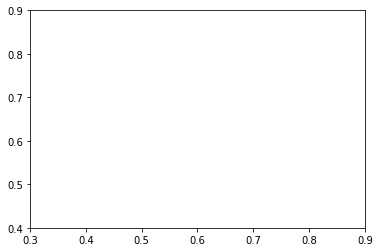

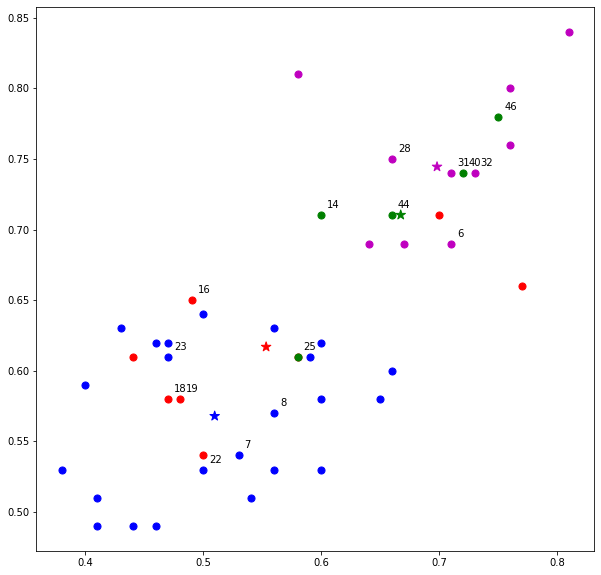

In [ ]:
# if __name__ == '__main__':
# 读取.csv文件
data_full = pd.read_csv("/content/drive/MyDrive/Projects/total-SD.csv")  # Iris.csv
# 得到表格的列名
columns = list(data_full.columns)
# 前四个列名是鸢尾花特征（最后一列是鸢尾花种类）
index = columns[0:1] 
features = columns[1:len(columns)]  # - 1
# 提取需要聚类的数据（根据列名提取前四列）
data_index = data_full[index]
data = data_full[features]
# 分类数
Clusters_number = 4
best_point_number = 4
# 最大迭代数
MAX_ITER = 100000
# 阈值
Epsilon = 0.0000001     # 0.0000001 
# 样本数，行数
n = len(data)
# 模糊参数
m = 1.2

# matplotlib需要array类型的数据
results, V, U = FCM()
V_array = np.array(V)
DATA_index = np.array(data_index)
DATA = np.array(data)
results = np.array(results)
# Xie-Beni聚类有效性
print("聚类有效性：", xie_beni(U, V_array, DATA))
best_points = best_point()
# 将DATA的第一列和第二列作为x、y轴绘图
xlim(0.3, 0.9)
ylim(0.4, 0.9)
# 创建一个绘图窗口
plt.figure(figsize=(10, 10))
# 画散点图
# 样本点   其中nonzero(results==0)为取出0这一类的下标
#j = 0
#while j < Clusters_number:
'''
请根据你分多少类，放开或屏蔽以下几行代码，分3类就是 0，1，2
'''
plt.scatter(DATA[nonzero(results == 0), 0], DATA[nonzero(results == 0), 1], marker='o', color='r', label='0', s=50)
plt.scatter(DATA[nonzero(results == 1), 0], DATA[nonzero(results == 1), 1], marker='o', color='g', label='1', s=50)
plt.scatter(DATA[nonzero(results == 2), 0], DATA[nonzero(results == 2), 1], marker='o', color='b', label='2', s=50)
plt.scatter(DATA[nonzero(results == 3), 0], DATA[nonzero(results == 3), 1], marker='o', color='m', label='3', s=50)
'''
plt.scatter(DATA[nonzero(results == 4), 0], DATA[nonzero(results == 4), 1], marker='o', color='y', label='4', s=10)
plt.scatter(DATA[nonzero(results == 5), 0], DATA[nonzero(results == 5), 1], marker='o', color='c', label='5', s=10)
plt.scatter(DATA[nonzero(results == 6), 0], DATA[nonzero(results == 6), 1], marker='o', color='b', label='6', s=10)
'''
# 中心点
'''
请根据你分多少类，添加或移除颜色定义， 分3类 color=['r', 'g', 'b']  分5类 color=['r', 'g', 'b', 'm', 'y', 'b']
'''
plt.scatter(V_array[:, 0], V_array[:, 1], marker='*', color=['r', 'g', 'b', 'm'], s=100)    # , 'c'
    #j += 1
n = np.arange(len(best_points))
for i, txt in enumerate(n):
    # c.append(i)
    plt.annotate(best_points[i][1], xy=(best_points[i][2], best_points[i][3]),
                    xytext=(best_points[i][2] + 0.005, best_points[i][3] + 0.005))
    # c[i]xy散点坐标，xytext标注坐标，xy，xytext也可不写，只需坐标信息
# plt.grid()
fig = plt.gcf()
plt.show()
fig.savefig('/content/drive/MyDrive/Projects/result.png', dpi=300)

In [ ]:
# 获取列表的第二个元素
def takeSecond(elem):
    return elem[-1]

In [ ]:
def best_point():
    best_points = []
    DATA_insert = np.insert(DATA, 7, values=results, axis=1)
    j = 0
    while j < Clusters_number:
        pop = []
        for i in range(len(data)):
            if DATA_insert[i, 7] == j:
                distance = np.sqrt(np.sum((np.array([DATA_insert[i, 3], DATA_insert[i, 4], DATA_insert[i, 5]]) - [V_array[j, 3], V_array[j, 4], V_array[j, 5]]) ** 2))
                    # np.sum((np.array([DATA_insert[i, 0], DATA_insert[i, 1]]) - [V_array[j, 0], V_array[j, 1]]) ** 2))
                pop.append([j, DATA_index[i,0], DATA_insert[i, 3], DATA_insert[i, 4], DATA_insert[i, 5], distance])
        pop.sort(key=takeSecond)
        # print('pop ')
        # print(pop)
        if len(pop) < best_point_number:
            r = len(pop)
        else:
            r = best_point_number
        for k in range(r):
            best_points.append(pop[k][0:5])
        # print('best_points ' + str(j))
        # print(best_points)
        j += 1
    # print(np.shape(best_points))
    for i in range(len(best_points)):
        print('clusters = ' + str(best_points[i][0]) + '  products = ' + str(best_points[i][1]))
    return best_points

用时：2.014108657836914 s
聚类有效性： 0.26172776840374307
clusters = 0  products = 46
clusters = 0  products = 40
clusters = 0  products = 43
clusters = 0  products = 44
clusters = 1  products = 21
clusters = 1  products = 20
clusters = 1  products = 16
clusters = 1  products = 25
clusters = 2  products = 9
clusters = 2  products = 32
clusters = 2  products = 27
clusters = 2  products = 6
clusters = 3  products = 33
clusters = 3  products = 26
clusters = 3  products = 37
clusters = 3  products = 8


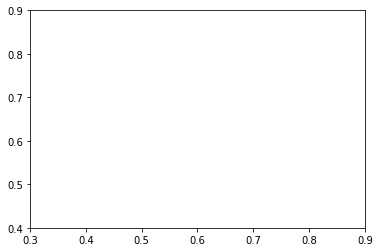

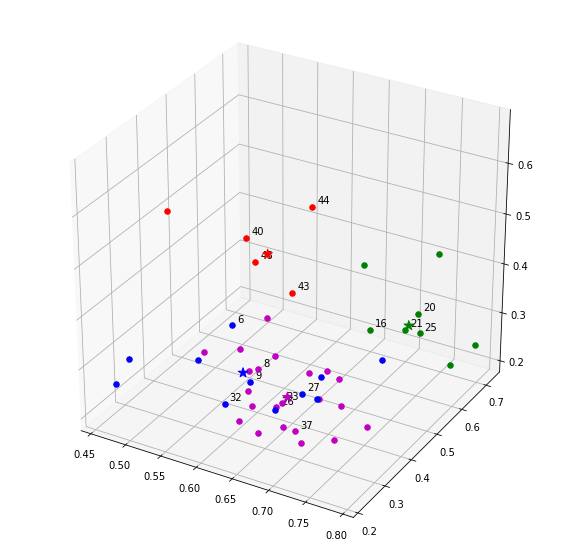

In [ ]:
# if __name__ == '__main__':
# 读取.csv文件
data_full = pd.read_csv("/content/drive/MyDrive/Projects/total-SD.csv")  # Iris.csv
# 得到表格的列名
columns = list(data_full.columns)
# 前四个列名是鸢尾花特征（最后一列是鸢尾花种类）
index = columns[0:1] 
features = columns[1:len(columns)]  # - 1
# 提取需要聚类的数据（根据列名提取前四列）
data_index = data_full[index]
data = data_full[features]
# 分类数
Clusters_number = 4
best_point_number = 4
# 最大迭代数
MAX_ITER = 100000
# 阈值
Epsilon = 0.0000001     # 0.0000001 
# 样本数，行数
n = len(data)
# 模糊参数
m = 1.5

# matplotlib需要array类型的数据
results, V, U = FCM()
V_array = np.array(V)
DATA_index = np.array(data_index)
DATA = np.array(data)
results = np.array(results)
# Xie-Beni聚类有效性
print("聚类有效性：", xie_beni(U, V_array, DATA))
best_points = best_point()
# 将DATA的第一列和第二列作为x、y轴绘图
xlim(0.3, 0.9)
ylim(0.4, 0.9)
# 创建一个绘图窗口
plt.figure(figsize=(10, 10))
plt3d = plt.gca(projection="3d")  # 创建三维坐标
# 画散点图
# 样本点   其中nonzero(results==0)为取出0这一类的下标
#j = 0
#while j < Clusters_number:
'''
请根据你分多少类，放开或屏蔽以下几行代码，分3类就是 0，1，2
'''
plt3d.scatter(DATA[nonzero(results == 0), 3], DATA[nonzero(results == 0), 4], DATA[nonzero(results == 0), 5], depthshade=False, marker='o', color='r', label='0', s=30) # cmap="jet", 
plt3d.scatter(DATA[nonzero(results == 1), 3], DATA[nonzero(results == 1), 4], DATA[nonzero(results == 1), 5], depthshade=False, marker='o', color='g', label='1', s=30)
plt3d.scatter(DATA[nonzero(results == 2), 3], DATA[nonzero(results == 2), 4], DATA[nonzero(results == 2), 5], depthshade=False, marker='o', color='b', label='2', s=30)
plt3d.scatter(DATA[nonzero(results == 3), 3], DATA[nonzero(results == 3), 4], DATA[nonzero(results == 3), 5], depthshade=False, marker='o', color='m', label='3', s=30)
'''
plt.scatter(DATA[nonzero(results == 4), 0], DATA[nonzero(results == 4), 1], marker='o', color='y', label='4', s=10)
plt.scatter(DATA[nonzero(results == 5), 0], DATA[nonzero(results == 5), 1], marker='o', color='c', label='5', s=10)
plt.scatter(DATA[nonzero(results == 6), 0], DATA[nonzero(results == 6), 1], marker='o', color='b', label='6', s=10)
'''
# 中心点
'''
请根据你分多少类，添加或移除颜色定义， 分3类 color=['r', 'g', 'b']  分5类 color=['r', 'g', 'b', 'm', 'y', 'b']
'''
plt3d.scatter(V_array[:, 3], V_array[:, 4], V_array[:, 5], depthshade=False, marker='*', color=['r', 'g', 'b', 'm'], s=100)    # , 'c'
    #j += 1
n = np.arange(len(best_points))
for i, txt in enumerate(n):
    # c.append(i)
    # plt3d.annotate(best_points[i][1], xyz=(best_points[i][2], best_points[i][3], best_points[i][4]), xyztext=(best_points[i][2] + 0.005, best_points[i][3] + 0.005, best_points[i][4] + 0.005))
    plt3d.text(best_points[i][2] + 0.005, best_points[i][3] + 0.005, best_points[i][4] + 0.005, best_points[i][1])
    # c[i]xy散点坐标，xytext标注坐标，xy，xytext也可不写，只需坐标信息

# plt.grid()
fig = plt.gcf()
plt.show()
fig.savefig('/content/drive/MyDrive/Projects/result_3D.png', dpi=300)

0.0000001 0.4302857584808482
0.1 13.704609676297348
0.5 31.64848470690577
0.55 19.654301692625676
0.6 11.059165615212379
1 19.532317089710148
10 10.205230458437102

